### Univariate forecasting - horizons greater than 1

Utilizes only the closing price to predict as there is no way to predict other feature's values in future as well. For multivariate to occur for horizons greater than 1, we need the values of those features at that time point too. Which is not the case.

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

import datetime
import os

from lts import LTSCell
from ltc import LTCCell

In [2]:
BTC_PRICES_DATA = 'D:/Uni/FYP/GitHub/BitForecast/ml/data/BTC_Prices.csv'
data = pd.read_csv(BTC_PRICES_DATA)

In [3]:
data.head()

,date,volume,close,open,max,min,change_percent
0,2014-01-01,10757,815.940002,805.940002,829.929993,770.969971,1.240787
1,2014-01-02,12812,856.909973,815.940002,886.210022,810.469971,5.021199
2,2014-01-03,9709,884.260010,856.909973,888.229980,839.440002,3.191705
3,2014-01-04,14239,924.690002,884.260010,932.159973,848.320007,4.572184
4,2014-01-05,21374,1014.739990,924.690002,1029.859985,911.359985,9.738397


In [4]:
data.drop(['volume', 'open', 'max', 'min', 'change_percent'], axis=1, inplace=True)
data.head()

,date,close
0,2014-01-01,815.940002
1,2014-01-02,856.909973
2,2014-01-03,884.260010
3,2014-01-04,924.690002
4,2014-01-05,1014.739990


### Format data

In [5]:
# Convert date object to datetime
data['date'] = pd.to_datetime(data['date'])

In [6]:
data.set_index('date', inplace=True)

In [7]:
btc_prices = pd.DataFrame(data['close']).rename(columns={ 'close': 'Price' })

In [8]:
btc_prices.head()

,Price
date,
2014-01-01,815.940002
2014-01-02,856.909973
2014-01-03,884.260010
2014-01-04,924.690002
2014-01-05,1014.739990


Filteration of dates till only 2015 above is not required since only this dataset is being used

In [9]:
# Sort ascending order of prices
btc_prices.sort_values('date', inplace=True)
btc_prices.head()

,Price
date,
2014-01-01,815.940002
2014-01-02,856.909973
2014-01-03,884.260010
2014-01-04,924.690002
2014-01-05,1014.739990


### Visualize data

In [11]:
timesteps = btc_prices.index.to_numpy()
prices = btc_prices['Price'].to_numpy()

In [12]:
# Create sequential splits at a specified point (80% train, 20% test)
split_size = int(.8 * len(prices))

X_viz, y_viz = timesteps[:split_size], prices[:split_size]
X_viz_, y_viz_ = timesteps[split_size:], prices[split_size:]

X_viz.shape, X_viz_.shape, y_viz.shape, X_viz_.shape

((2648,), (663,), (2648,), (663,))

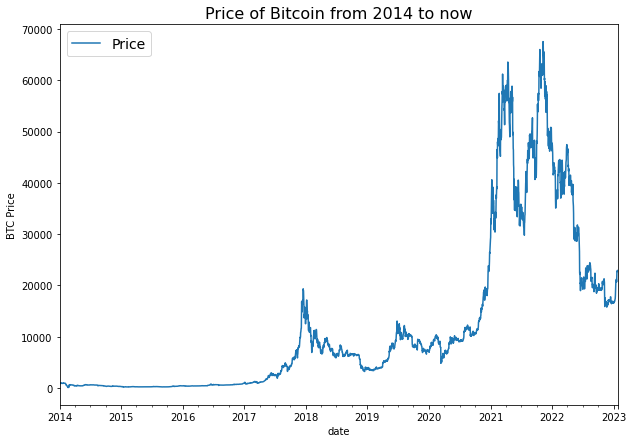

In [13]:
# Visualize closing prices
btc_prices.plot(figsize=(10, 7))
plt.ylabel('BTC Price')
plt.title('Price of Bitcoin from 2014 to now', fontsize=16)
plt.legend(fontsize=14);

In [15]:
# Create a helper plotting function
def plot_time_series(
    timesteps,
    prices,
    format='.',
    start=0,
    end=None,
    label=None
):
    plt.plot(timesteps[start:end], prices[start:end], format, label=label)
    plt.xlabel('Date')
    plt.ylabel('Price')
    if label:
        plt.legend(fontsize=14)

    # Display a grid for easier measurement readings
    plt.grid(True)

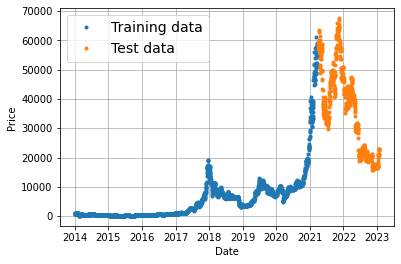

In [16]:
plot_time_series(X_viz, y_viz, label='Training data')
plot_time_series(X_viz_, y_viz_, label='Test data')

### Create windowed datasets

In [17]:
'''
Upon experimentation conducted in the
https://github.com/Ammar-Raneez/FYP_Algorithm/blob/main/experiments/experiments.ipynb
The below were the optimal window and horizon values
'''

HORIZON = 1
WINDOW_SIZE = 7

In [18]:
btc_prices_windowed = btc_prices.copy()

In [19]:
for i in range(WINDOW_SIZE):
    btc_prices_windowed[f'Price+{i+1}'] = btc_prices_windowed['Price'].shift(periods=i+1)

btc_prices_windowed.head(10)

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
date,,,,,,,,
2014-01-01,815.940002,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-02,856.909973,815.940002,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,884.260010,856.909973,815.940002,NaN,NaN,NaN,NaN,NaN
2014-01-04,924.690002,884.260010,856.909973,815.940002,NaN,NaN,NaN,NaN
2014-01-05,1014.739990,924.690002,884.260010,856.909973,815.940002,NaN,NaN,NaN
2014-01-06,1012.650024,1014.739990,924.690002,884.260010,856.909973,815.940002,NaN,NaN
2014-01-07,879.900024,1012.650024,1014.739990,924.690002,884.260010,856.909973,815.940002,NaN
2014-01-08,938.840027,879.900024,1012.650024,1014.739990,924.690002,884.260010,856.909973,815.940002
2014-01-09,936.950012,938.840027,879.900024,1012.650024,1014.739990,924.690002,884.260010,856.909973


In [20]:
# Create X (windows) and y (horizon)
X = btc_prices_windowed.dropna().drop('Price', axis=1).astype(np.float32)
y = btc_prices_windowed.dropna()['Price'].astype(np.float32)

In [21]:
X.head()

,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
date,,,,,,,
2014-01-08,879.900024,1012.650024,1014.739990,924.690002,884.260010,856.909973,815.940002
2014-01-09,938.840027,879.900024,1012.650024,1014.739990,924.690002,884.260010,856.909973
2014-01-10,936.950012,938.840027,879.900024,1012.650024,1014.739990,924.690002,884.260010
2014-01-11,957.760010,936.950012,938.840027,879.900024,1012.650024,1014.739990,924.690002
2014-01-12,1005.320007,957.760010,936.950012,938.840027,879.900024,1012.650024,1014.739990


In [22]:
y.head()

date
2014-01-08     938.840027
2014-01-09     936.950012
2014-01-10     957.760010
2014-01-11    1005.320007
2014-01-12     939.789978
Name: Price, dtype: float32

In [23]:
split_size = int(len(X) * .8)

X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2643, 2643, 661, 661)

### Create performant tensorflow datasets

`tf.data` API creates more optimized datasets that can make the model run faster

In [24]:
# create tensorflow Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine features and labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# batch and prefetch for optimal performance
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>)